In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.optimize import root_scalar
from util import load_sample,load_acertos, provas, params_inep, irt_params_to_enem_scale,item_info_inep, scalecalparams, item_stats, PL3

%load_ext autoreload
%autoreload 2

# O modelo TRI funciona?
Um notebook para aferir se os ajustes feitos pelos INEP, usando o modelo PL3, funcionam bem na prática. Vamos comparar as curvas característas dos itens (a probabilidade de acerto $P(\theta|a,b,c)$ em função de $\theta$) com as curvas características empíricas (a fração dos candidatos que acertaram o item, para cada faixa de $\theta$). 

In [2]:
# Primeiro, uma função para recuperar os parâmetros TRI dos itens dado pelo INEP, 
# junto as estatísticas da teoria clássica de testes. Ambos já estã organizados na
# pasta ./data, feito no notebook 00-PrepareData
ano = 2019
def get_istats(ano,area=None):
    if area:
        areas=[area]
    else:
        areas = ['MT','CN','CH','LC']
    l=[]
    for area in areas:
        fn = f'data/istats-{ano}-{area}.csv'
        df = pd.read_csv(fn,index_col='item',dtype={'item':str})
        l.append(df)
    return pd.concat(l)


istats = get_istats(ano,'MT')
istats

,N,mean,sd,total.r,url,CO_POSICAO,SG_AREA,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
item,,,,,,,,,,,,,,,,,,,,
63187,31596,0.474965,0.499381,0.422689,https://www.curso-objetivo.br/vestibular/resol...,144,MT,D,1.0,0,NaN,1.86876,0.42930,0.12552,AMARELA,516,2019,NaN,0.0,NaN
117612,31596,0.193980,0.395420,0.166390,https://www.curso-objetivo.br/vestibular/resol...,145,MT,B,17.0,0,NaN,1.94459,2.78766,0.16241,AMARELA,516,2019,NaN,0.0,NaN
63808,31596,0.142740,0.349813,0.326465,https://www.curso-objetivo.br/vestibular/resol...,146,MT,E,9.0,0,NaN,2.89605,1.98685,0.08712,AMARELA,516,2019,NaN,0.0,NaN
54448,31596,0.373370,0.483707,0.516329,https://www.curso-objetivo.br/vestibular/resol...,147,MT,B,20.0,0,NaN,3.06326,0.80679,0.08034,AMARELA,516,2019,NaN,0.0,NaN
86432,31596,0.611438,0.487431,0.307027,https://www.curso-objetivo.br/vestibular/resol...,148,MT,A,1.0,0,NaN,1.12267,0.37213,0.26876,AMARELA,516,2019,NaN,0.0,NaN
23065,31596,0.158786,0.365482,0.029760,https://www.curso-objetivo.br/vestibular/resol...,149,MT,C,14.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,AMARELA,516,2019,NaN,0.0,NaN
117798,31596,0.159830,0.366454,0.070411,https://www.curso-objetivo.br/vestibular/resol...,150,MT,A,26.0,0,NaN,2.72919,1.92868,0.23186,AMARELA,516,2019,NaN,0.0,NaN
30740,31596,0.315546,0.464740,0.323879,https://www.curso-objetivo.br/vestibular/resol...,151,MT,B,12.0,0,NaN,1.64938,1.94549,0.20724,AMARELA,516,2019,NaN,0.0,NaN
30436,31596,0.273073,0.445545,0.328167,https://www.curso-objetivo.br/vestibular/resol...,152,MT,C,12.0,0,NaN,1.64692,0.47926,0.18811,AMARELA,516,2019,NaN,0.0,NaN


In [4]:
# Temos as notas na escala ENEM, mas vamos trabalhar na "escala logit", 
def notas_to_logit_scale(notas,area):
    slope,intercept = scalecalparams(area)
    return (notas-intercept)/slope

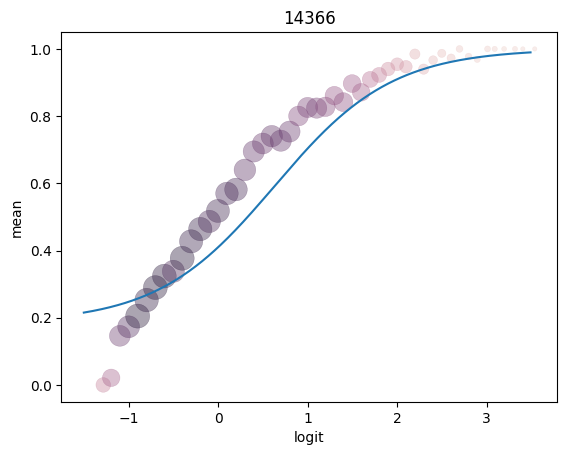

In [13]:
# A figura com a curva teórica sobrepost com a curva empírica
def item_notas(item,notas):
    ''
    ac = notas.loc[:,[item,'nota_inep','nota_inep_logit']]
    return ac

def itemplot(item,notas,ax=None):
    if not ax:
        ax = plt.gca()
    acertosnotas = item_notas(item,notas)
    gb = acertosnotas.groupby(acertosnotas['nota_inep_logit'].apply(lambda x:round(x,1))).agg({item:['count','mean'],'nota_inep':'mean','nota_inep_logit':'mean'})
    gb.columns = ['count','mean','nota_inep','logit']
    sns.scatterplot(gb,x='logit',y='mean',hue='count',size='count',sizes=(10, 300),ec="face",alpha=0.4,ax=ax,legend=False)
    thetas = np.arange(-1.5,3.5,0.01)
    a,b,c = istats.loc[item][['NU_PARAM_A','NU_PARAM_B','NU_PARAM_C']]
    sns.lineplot(x=thetas,y=PL3(thetas,a,b,c),ax=ax)
    ax.set_title(item)

ano = 2023
area = 'MT'
istats = get_istats(ano,area)
item = random.choice(istats.index) # um item aleatório
notas = load_acertos(ano,area)
notas['nota_inep_logit'] = notas_to_logit_scale(notas['nota_inep'],area)
itemplot(item,notas)


Agora que temos uma figura para 1 item, é mais fácil generalizar para todos os itens de um prova.

In [14]:
ano =2015
area = 'MT'
istats = get_istats(ano,area)
istats = istats.sort_values('NU_PARAM_B')

notas = load_acertos(ano,area,remove_abandonados=False)
notas  = notas.rename(lambda s: s.rstrip('-aban'),axis=1)
notas['nota_inep_logit'] = notas_to_logit_scale(notas['nota_inep'],area)

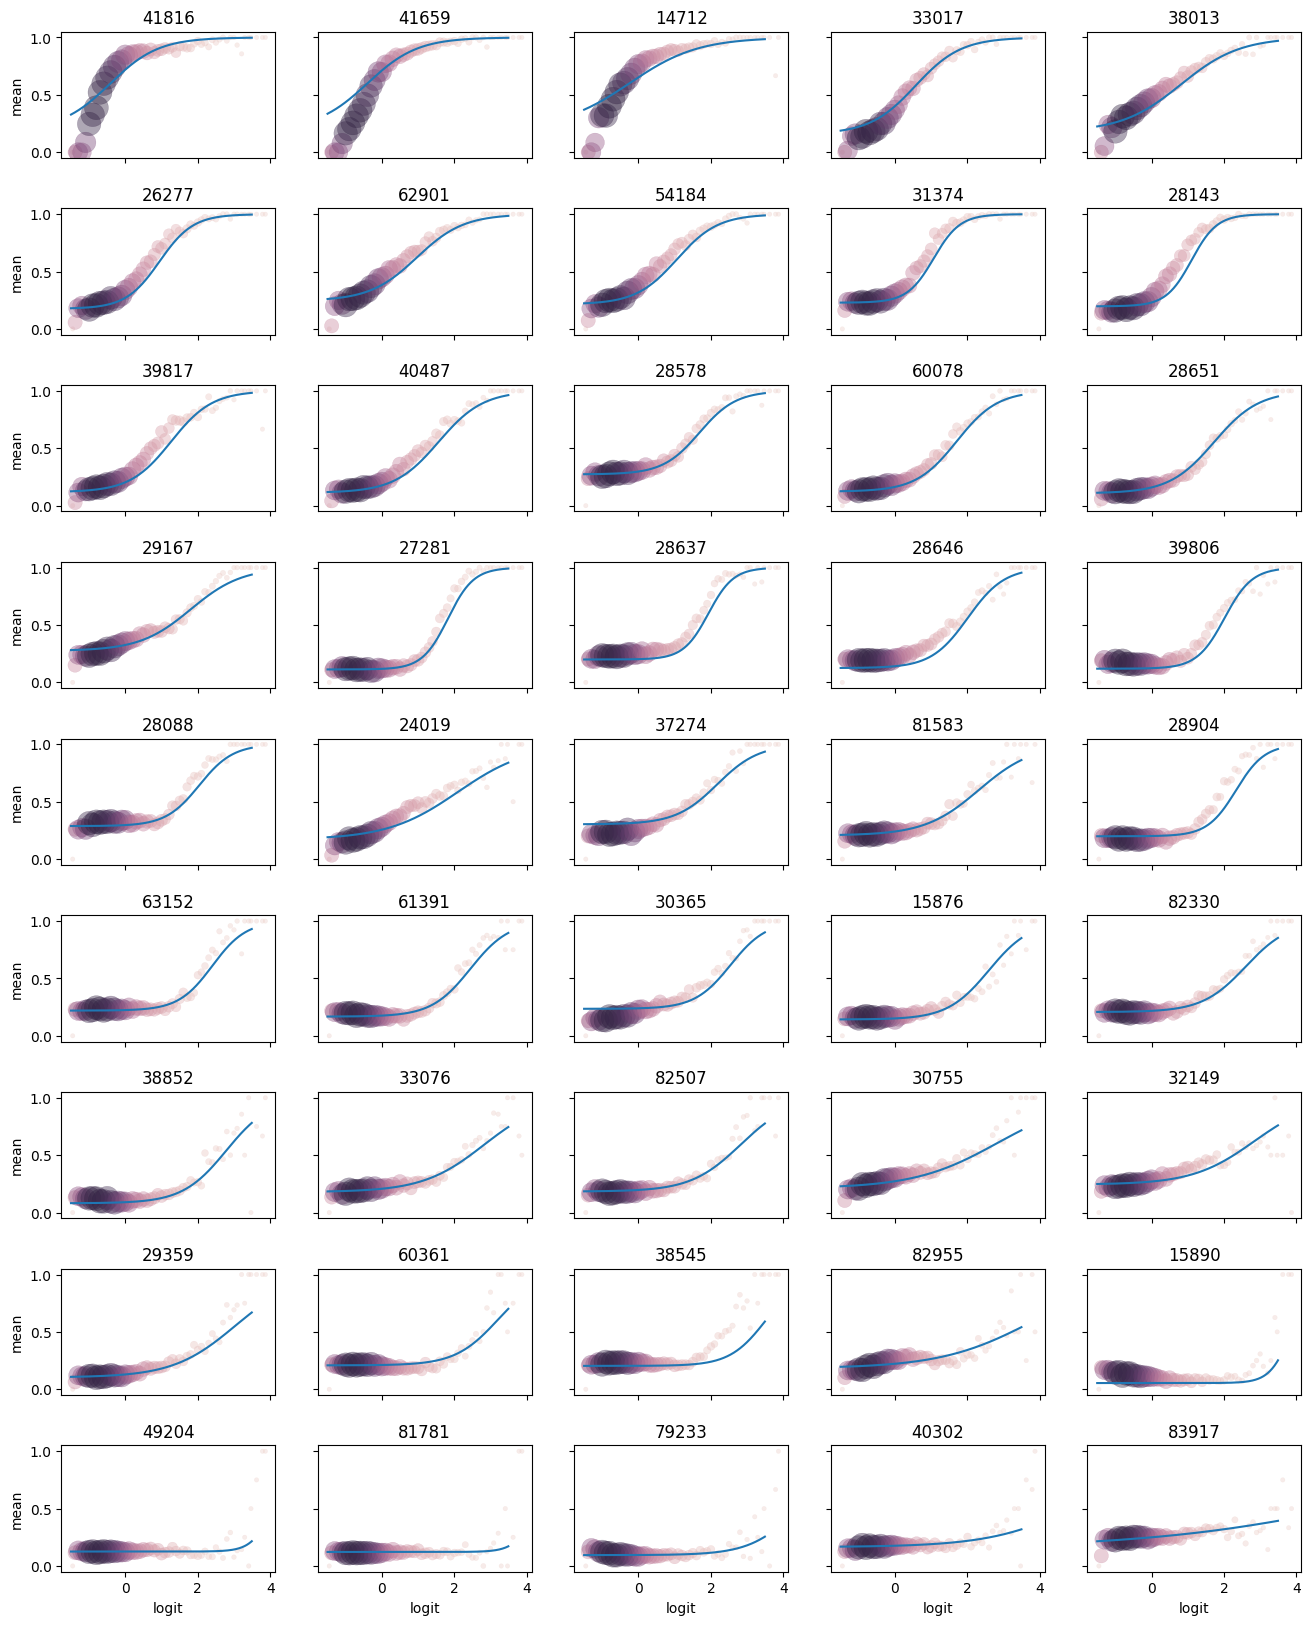

In [15]:
fig,axs = plt.subplots(9,5,sharex=True, sharey=True,figsize=(16,20))
i=0
for axrow in axs:
    for ax in axrow:
        item = istats.index[i]
        i = i + 1
        itemplot(item,notas,ax)
plt.subplots_adjust(hspace=0.4)

In [166]:
istats.index[-1]

'83917'

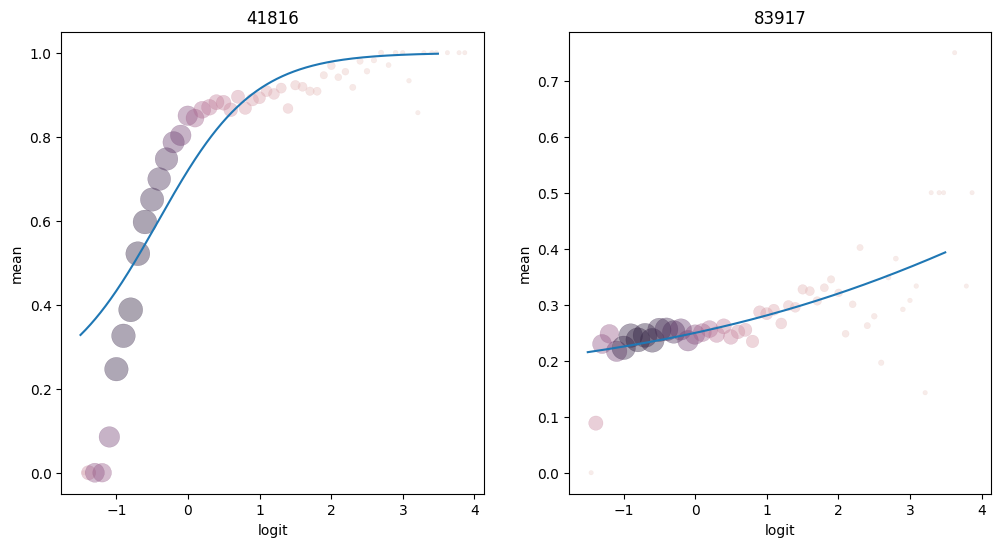

In [18]:
# O item mais fácil e o item mais difícil)
_, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
itemplot(istats.index[0],notas,ax1)
itemplot(istats.index[-1],notas,ax2)

In [19]:
istats

,N,mean,sd,total.r,url,CO_POSICAO,SG_AREA,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
item,,,,,,,,,,,,,,,,,,,,
41816,43959,0.597534,0.490400,0.333652,https://www.curso-objetivo.br/vestibular/resol...,178,MT,B,26.0,0,NaN,1.49174,-0.42299,0.19323,AMARELA,243,2015,NaN,0.0,NaN
41659,43959,0.496554,0.499994,0.401039,https://www.curso-objetivo.br/vestibular/resol...,138,MT,B,15.0,0,NaN,1.44654,-0.39957,0.20014,AMARELA,243,2015,NaN,0.0,NaN
14712,43959,0.574922,0.494360,0.358709,https://www.curso-objetivo.br/vestibular/resol...,180,MT,C,28.0,0,NaN,1.06024,-0.23853,0.20527,AMARELA,243,2015,NaN,0.0,NaN
33017,43959,0.328784,0.469777,0.422888,https://www.curso-objetivo.br/vestibular/resol...,141,MT,D,20.0,0,NaN,1.58698,0.56570,0.15746,AMARELA,243,2015,NaN,0.0,NaN
38013,43959,0.406128,0.491115,0.336009,https://www.curso-objetivo.br/vestibular/resol...,172,MT,D,17.0,0,NaN,1.22540,0.80613,0.17857,AMARELA,243,2015,NaN,0.0,NaN
26277,43959,0.340954,0.474035,0.397006,https://www.curso-objetivo.br/vestibular/resol...,143,MT,A,8.0,0,NaN,2.15675,0.94349,0.17590,AMARELA,243,2015,NaN,0.0,NaN
62901,43959,0.396574,0.489192,0.359697,https://www.curso-objetivo.br/vestibular/resol...,177,MT,E,1.0,0,NaN,1.54884,0.96427,0.24491,AMARELA,243,2015,NaN,0.0,NaN
54184,43959,0.365113,0.481467,0.371206,https://www.curso-objetivo.br/vestibular/resol...,154,MT,B,23.0,0,NaN,1.76806,1.06274,0.21458,AMARELA,243,2015,NaN,0.0,NaN
31374,43959,0.344412,0.475182,0.395721,https://www.curso-objetivo.br/vestibular/resol...,173,MT,B,16.0,0,NaN,2.75038,1.06733,0.22876,AMARELA,243,2015,NaN,0.0,NaN


In [157]:
item_info_inep(2019,'CN')

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
17930,91,CN,27903,D,27.0,0,NaN,2.13248,1.45511,0.18122,CINZA,544,2019,NaN,0.0,NaN
17931,91,CN,31718,D,28.0,0,NaN,1.90483,0.48421,0.21286,ROSA,506,2019,NaN,0.0,NaN
17932,91,CN,32818,C,2.0,0,NaN,1.61135,1.52847,0.12627,AMARELA,543,2019,NaN,0.0,NaN
17933,91,CN,82364,A,27.0,0,NaN,2.43167,1.13773,0.22233,AZUL,503,2019,NaN,0.0,NaN
17934,91,CN,89925,C,17.0,0,NaN,1.72007,0.75412,0.26095,ROSA,546,2019,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18375,135,CN,85112,E,30.0,0,NaN,2.37172,0.19119,0.10626,AMARELA,543,2019,NaN,0.0,NaN
18376,135,CN,96533,A,2.0,0,NaN,2.08707,1.27433,0.33679,CINZA,544,2019,NaN,0.0,NaN
18377,135,CN,97322,B,20.0,0,NaN,2.41465,1.28437,0.21462,AZUL,545,2019,NaN,0.0,NaN
18378,135,CN,97997,D,18.0,0,NaN,2.32257,0.47932,0.13509,ROSA,546,2019,NaN,0.0,NaN
